In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.decomposition import PCA

# 5. PCA

In [2]:
num_imgs = len(os.listdir("preprocessed"))
images = np.empty((num_imgs, 64, 64), dtype=np.uint8)
for i, image in enumerate(os.listdir("preprocessed")):
    im = Image.open("preprocessed/" + image)
    images[i,:,:] = np.array(im)

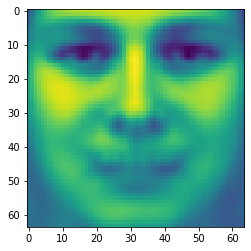

In [9]:
mean_image = images.mean(axis=0)
plt.imshow(mean_image)

In [24]:
centered = images - mean_image
centered = centered.reshape(centered.shape[0], 64*64)

In [16]:
pca = PCA()
pca.fit(centered)

PCA()

In [22]:
transformed = pca.transform(centered)

In [25]:
transformed.shape

(396, 396)

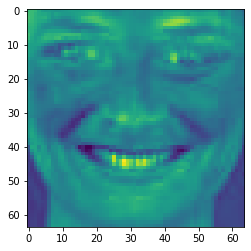

In [23]:
plt.imshow(pca.inverse_transform(transformed[0]).reshape(64,64))